# Stroke prediction

## Introduction

The goal of this model is to predict if a person is going to suffer a stroke.

Since false negative are more important (false positives can be checked at the hospital), we are going to add more weight on those in the loss function. 

### Background

A stroke occurs when the blood supply to part of your brain is interrupted or reduced, preventing brain tissue from getting oxygen and nutrients. Brain cells begin to die in minutes. A stroke is a medical emergency, and prompt treatment is crucial. Early action can reduce brain damage and other complications. The good news is that many fewer Americans die of stroke now than in the past. Effective treatments can also help prevent disability from stroke.

- [ ] Split training dataset:
  - [ ] Regular
  - [ ] MCA (requires binning)
- [ ] Apply SMOTE to MCA dataset (https://imbalanced-learn.org/stable/common_pitfalls.html#data-leakage)
- [ ] Try decisions trees over regular and mca dataset
- [ ] F1-score

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import imblearn

from bokeh.io import push_notebook, output_notebook, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum
output_notebook()

sns.set_style('whitegrid')
cmap = sns.cm.mako_r

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
from sklearn.utils import check_random_state
np.random.seed(42)
assert check_random_state is not None, "Set numpy seed for determinism."

In [3]:
df = pd.read_csv('../dataset/stroke.csv').drop(columns=['id'])

In [4]:
df.shape

(5110, 11)

In [5]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
categorical_cols = df.select_dtypes(include=object).columns
binary_cols = ['stroke', 'hypertension', 'heart_disease']
numerical_cols = df.select_dtypes(include=np.number).columns.drop(binary_cols)
print(f'Numerical variables: {len(numerical_cols)}')
print(f'Binary variables: {len(binary_cols)}')
print(f'Categorical variables: {len(categorical_cols)}')

Numerical variables: 3
Binary variables: 3
Categorical variables: 5


In [7]:
df[numerical_cols].describe()

age  avg_glucose_level          bmi
count  5110.000000        5110.000000  4909.000000
mean     43.226614         106.147677    28.893237
std      22.612647          45.283560     7.854067
min       0.080000          55.120000    10.300000
25%      25.000000          77.245000    23.500000
50%      45.000000          91.885000    28.100000
75%      61.000000         114.090000    33.100000
max      82.000000         271.740000    97.600000

In [8]:
df[categorical_cols].describe()

gender ever_married work_type Residence_type smoking_status
count     5110         5110      5110           5110           5110
unique       3            2         5              2              4
top     Female          Yes   Private          Urban   never smoked
freq      2994         3353      2925           2596           1892

## Preprocessing

Age should be rounded to a natural.

In [9]:
df['age'] = df['age'].apply(round)

Binning can be applied to continuous values. The values are taken from the articles:

- [Body Mass Index](https://www.medicalnewstoday.com/articles/323446#body-mass-index)
- [Average Glucose](https://agamatrix.com/blog/normal-blood-sugar-level-chart/)

In [10]:
#df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
#df['age_cat'] = pd.cut(df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
#df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

### Dealing with outliers

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>,
        <AxesSubplot:title={'center':'bmi'}>]], dtype=object)

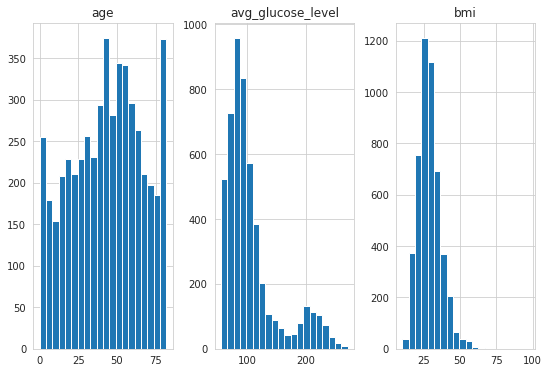

In [11]:
df[numerical_cols].hist(bins=20, layout=(1,3), figsize=(9,6))

array([<AxesSubplot:title={'center':'age'}>], dtype=object)

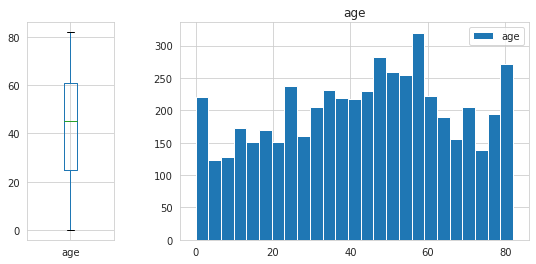

In [12]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,4))
df.boxplot(column='age',ax=axes[0])
df.hist(bins=25, column='age', ax=axes[1], legend=True)

Here we could have used IQR filtering but it would have removed the values of the extrem of the interval which is no good.

After some research (see [Overweight & Obesity](https://www.cdc.gov/obesity/adult/defining.html)), we consider a BMI less than 15 and greater than 60 an outlier.

In [13]:
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 15 < bmi_value < 60 else np.nan)

There is only one person with 'Other' gender so we will consider it an outlier.

In [14]:
df = df[df['gender'] != 'Other']

### Replace Low Frequency Categorical Variables

In [15]:
def replaceLowFreq(df, threshold=0.1, replacement='other'):
    f = lambda x: x.map(x.value_counts(normalize=True)) >= threshold
    r = df[categorical_cols].where(df[categorical_cols].apply(f), replacement)
    df[categorical_cols] = r

replaceLowFreq(df, threshold=0.1)

### Imputation

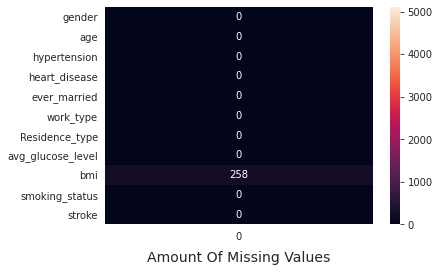

In [16]:
def displayMissingValues():
    plt.title('Amount Of Missing Values',fontsize=14, y=-0.2)
    ax = sns.heatmap(pd.DataFrame(df.isna().sum()),annot=True, fmt='d', vmin=0, vmax=df.shape[0])
displayMissingValues()

A naive imputation such as the *mean of all non missing bmi* will not work since 'bmi' depends on other variables e.g. 'age', 'gender', etc.

```python
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

X = np.array(df.bmi).reshape(-1,1)
df.bmi = imp_mean.fit_transform(X)
```

This is why we are going to impute the missing bmi values using a Decision Tree based with variables age and gender.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

imp_dt = DecisionTreeRegressor(random_state=42)

pipe = \
  Pipeline(steps=[('scale',StandardScaler()), 
                  ('imputer', imp_dt)])

X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
pipe.fit(X,Y)
predicted_bmi = pd.Series(pipe.predict(Missing[['age','gender']]), index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

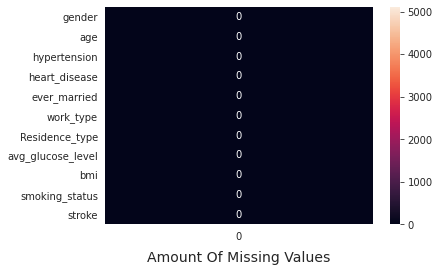

In [18]:
displayMissingValues()

## Visualization

First, let's display the data grouped by target class.

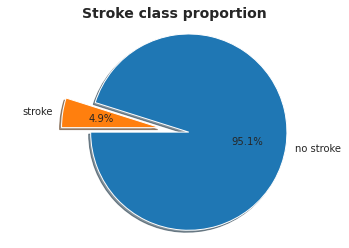

In [19]:
fig1, ax1 = plt.subplots()
ax1.pie(df['stroke'].value_counts(), explode=[0, 0.3], labels=['no stroke', 'stroke'], autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.set_title('Stroke class proportion', loc='center', y=1.0, fontsize=14, fontweight='bold')
ax1.axis('equal')

plt.show()

The dataset is **imbalanced**. We will take this into account in the next sections by using a resampling method such as SMOTE.

In [20]:
from math import pi

len_data = len(df)
len_m = len(df[df["gender"]=="Male"])
len_w = len_data - len_m

men_stroke = len(df.loc[(df["stroke"]==1)&(df['gender']=="Male")])
men_no_stroke = len_m - men_stroke

women_stroke = len(df.loc[(df["stroke"]==1) & (df['gender']=="Female")])
women_no_stroke = len_w - women_stroke

x = {
    'Men with stroke': men_stroke,
    'Women with stroke': women_stroke,
    'Men healthy': men_no_stroke,
    'Women healthy': women_no_stroke
}
          
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'label'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(x)]

p = figure(plot_height=350, toolbar_location=None,
           tools="hover", tooltips="@label: @value", x_range=(-0.5, 1.0))
p.title.text = 'Stroke class grouped by gender'
p.title.align = 'center'
p.title.text_color = 'black'
p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='label', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

array([<AxesSubplot:ylabel='age'>, <AxesSubplot:ylabel='hypertension'>,
       <AxesSubplot:ylabel='heart_disease'>,
       <AxesSubplot:ylabel='avg_glucose_level'>,
       <AxesSubplot:ylabel='bmi'>], dtype=object)

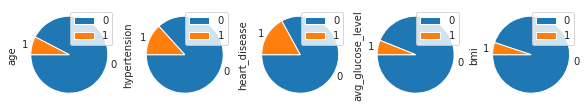

In [21]:
df.groupby(['stroke']).sum().plot(kind='pie', subplots=True, figsize=(10,5), startangle=180)

The classes representation seems to be proportioned when partition by each numerical variable except for hypertension and heart_disease.

Now, let's have a look at the rest of variables and check if they are properly balanced.

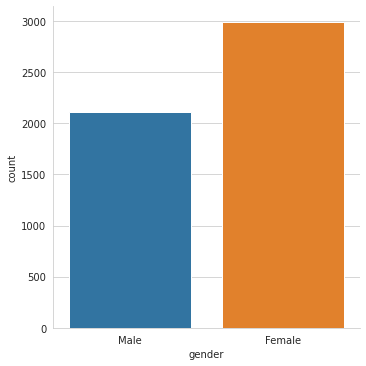

In [22]:
sns.catplot(x='gender', kind='count', data=df)

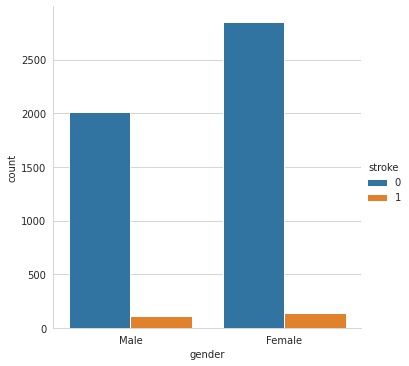

In [23]:
sns.catplot(x='gender', hue='stroke', kind='count', data=df)

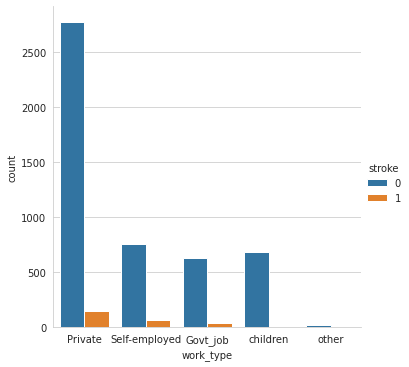

In [24]:
sns.catplot(x="work_type", hue="stroke", kind="count", data=df)

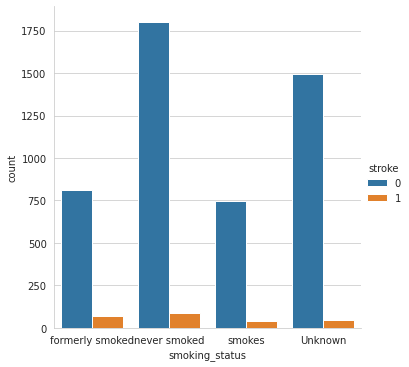

In [25]:
sns.catplot(x="smoking_status", hue="stroke", kind="count", data=df)

Stroke doesn't seem to be highly correlated to smoke since the proportion of person having a strok is farily the same among the different smoking status.

Men are more prone to stroke than women.

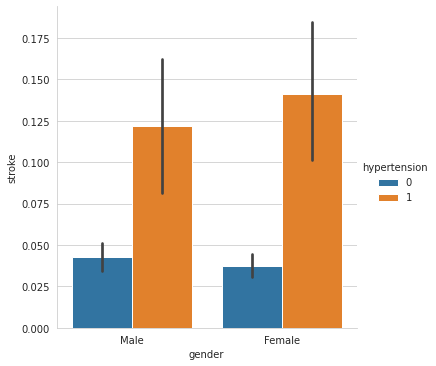

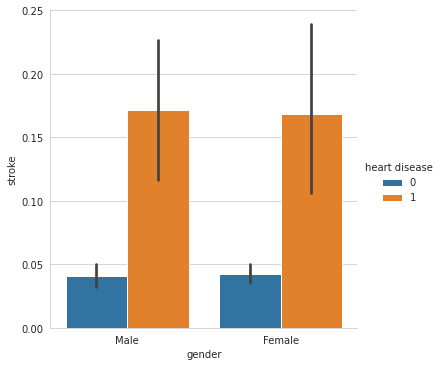

In [26]:
sns.catplot(x="gender", y="stroke", hue="hypertension", kind="bar", data=df)
g = sns.catplot(x="gender", y="stroke", hue="heart_disease", kind="bar", data=df)
g.legend.set_title("heart disease")

- The gender does not discriminite a person having a stroke or not.
- Hypertension and heart disease does affect a person having a stroke.

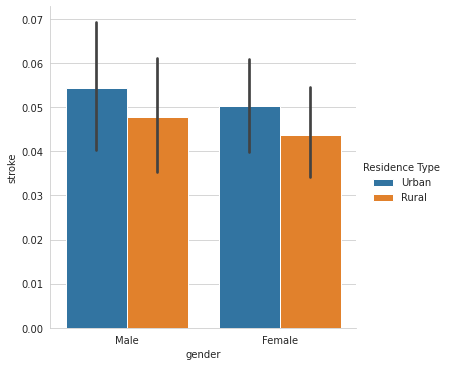

In [27]:
g = sns.catplot(x="gender", y="stroke", hue="Residence_type", kind="bar", data=df)
g.legend.set_title('Residence Type')

- Rural people is less prone to stroke.

Let's have a look at the attributes and its histograms.

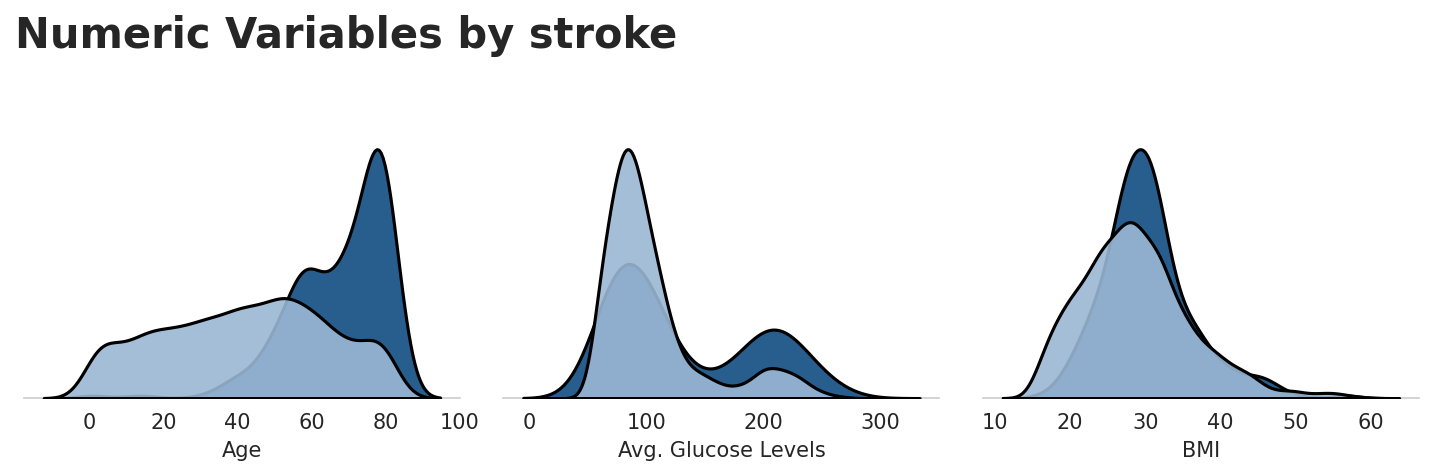

In [28]:
fig = plt.figure(figsize=(12, 12), dpi=150)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in numerical_cols:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(-20, 0.056, 'Numeric Variables by stroke', fontsize=20, fontweight='bold')

plt.show()

Age looks to be a prominent factor.

## Correlation

In [29]:
fig = px.parallel_categories(df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status', 'stroke']], color='stroke', color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

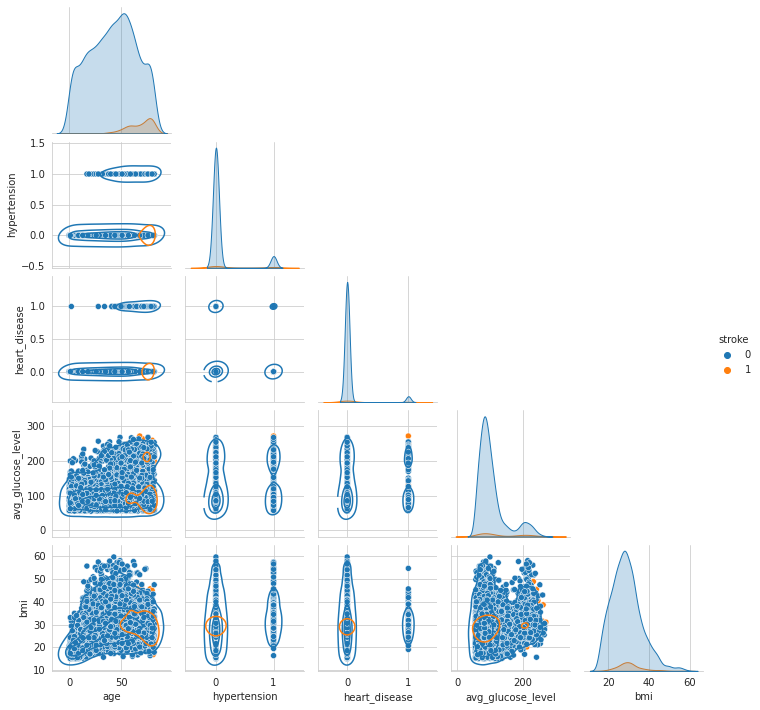

In [30]:
# This is terribly slow...
g = sns.pairplot(df, diag_kind="kde", hue='stroke', corner=True, height=2.0)
g.map_lower(sns.kdeplot, levels=4, color=".2")

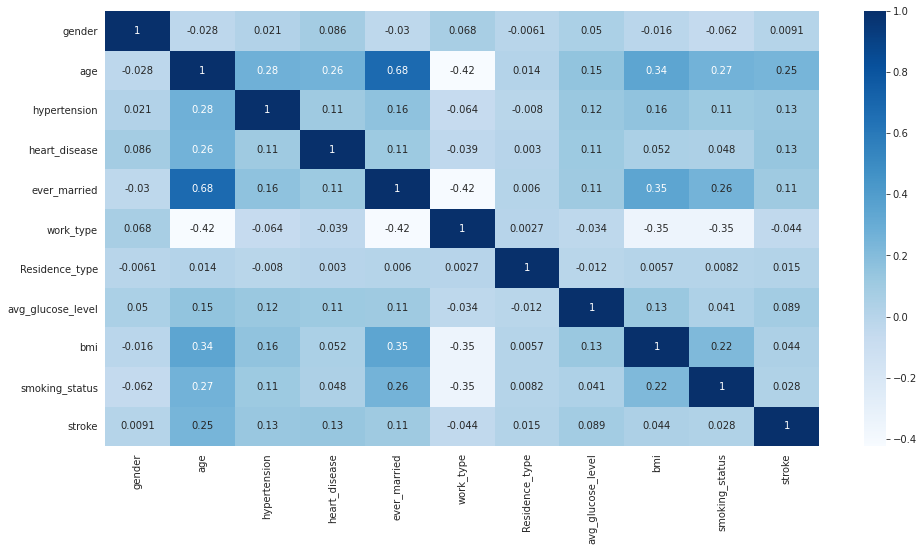

In [31]:
from sklearn.preprocessing import LabelEncoder

# 0 to n-1
encoder = LabelEncoder()
df_aux = df.apply(encoder.fit_transform)

# plt.figure(figsize=(16,8))
# sns.heatmap(df.corr(),cmap="Blues", annot=True);

plt.figure(figsize=(16,8))
sns.heatmap(df_aux.corr(),cmap="Blues", annot=True);

## Modeling

Since the dataset is imbalanced, a useful baseline to beat is the _the null accuracy_. We will use the inverse since we are predicting the positive case 'stroke'.  

Our baseline will be $\approx 5\%$ for recall of positive stroke.

We are not going to extract new values such as _age_group_(children, youth, adult, seniors).

In [32]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'stroke']
y = df['stroke']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
import prince

def runMCA(X, n_components):
  mca = prince.MCA(
          n_components=n_components,
          n_iter=100,
          copy=True,
          check_input=True,
          engine='auto',
          random_state=42)

  mca = mca.fit(X)
    
  plt.plot(np.cumsum(mca.explained_inertia_))
  plt.title('Cumulative sum of inertia')
    
  mca.plot_coordinates(
    X=X,
    ax=None,
    figsize=(12, 12),
    show_row_points=True,
    row_points_size=10,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=30,
    show_column_labels=True,
    legend_n_cols=1)

  return mca

MCA(n_components=10, n_iter=100, random_state=42)

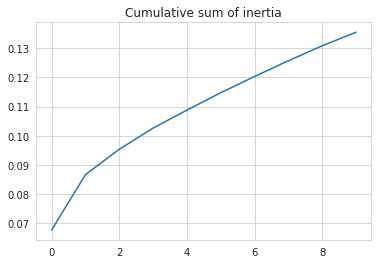

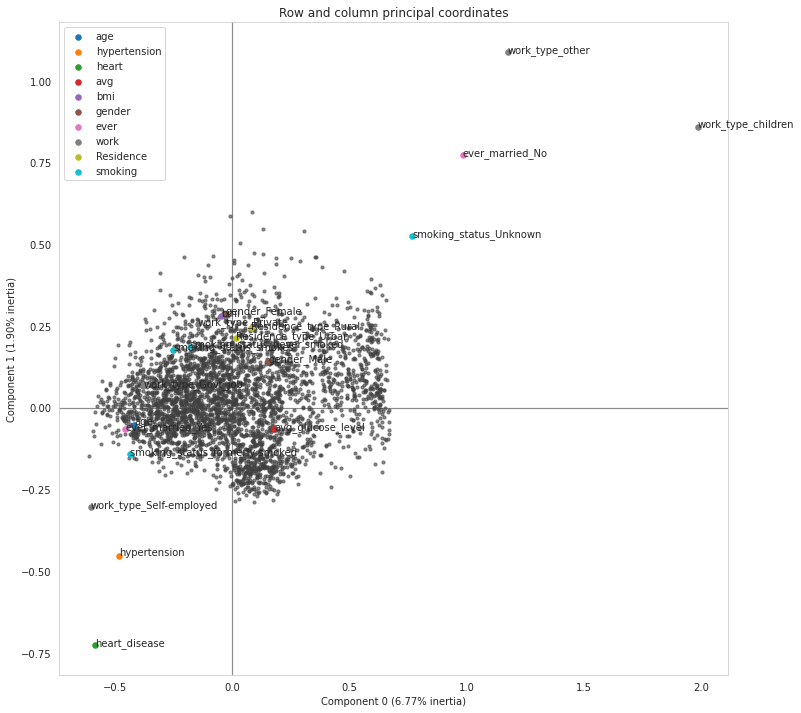

In [34]:
runMCA(X=X_train, n_components=10)

The inertia is really low.

Let's try binning the numerical variables into categorical ones in order to use them on the MCA.

In [35]:
def binNumericalVariables(X):
  r = X.copy()
  r.drop(columns=['age', 'bmi', 'avg_glucose_level'])
  r['age'] = pd.cut(X_train['age'], bins=[0,13,18,45,60,150], labels=['children', 'teens', 'adults', 'seniors', 'elderly'])
  r['bmi'] = pd.cut(X_train['bmi'], bins=[0,19,25,30,300], labels=['underweight', 'normal', 'overweight', 'obesity'])
  r['avg_glucose_level'] = pd.cut(X_train['avg_glucose_level'], bins=[0,90,160,230,500], labels=['low','normal','high','very high']) 
  return r

The glucose level binning is extracted from this [blog](https://agamatrix.com/blog/normal-blood-sugar-level-chart/).

In [36]:
X_train_mca = binNumericalVariables(X_train)

In [37]:
X_train_mca.dtypes

gender                 object
age                  category
hypertension            int64
heart_disease           int64
ever_married           object
work_type              object
Residence_type         object
avg_glucose_level    category
bmi                  category
smoking_status         object
dtype: object

All variables are now encoded as binary or categorical

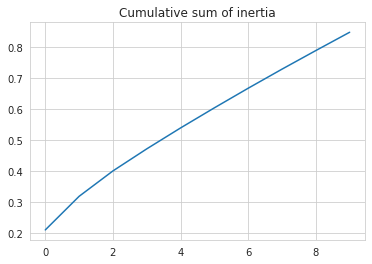

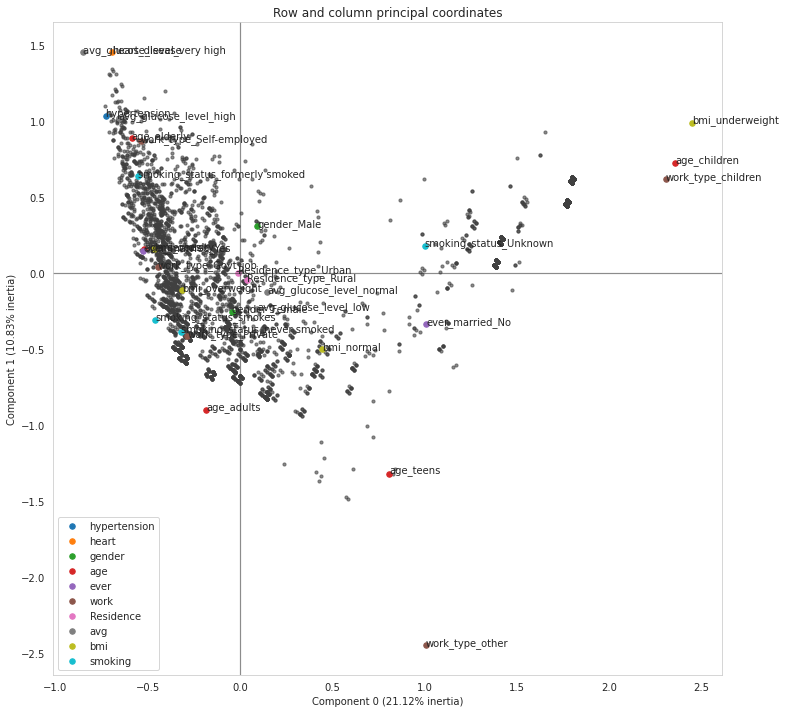

In [38]:
mcaModel=runMCA(X_train_mca, n_components=10)

### Categorical encoding

In [39]:
X_train_one = pd.get_dummies(X_train, columns = categorical_cols, drop_first=True)
X_train_one.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Male', 'ever_married_Yes', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'work_type_other',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

### Over-sampling

The learning phase and the subsequent prediction of machine learning algorithms can be affected by the problem of imbalanced data set. The balancing issue corresponds to the difference of the number of samples in the different classes.

Before applying SMOTE we are going to check the different *clusters* of our data.

In [40]:
from imblearn.over_sampling import SMOTE

m = SMOTE(random_state=42, k_neighbors=5)
X_train_one_re, y_train_one_re = m.fit_resample(X_train_one, y_train.ravel())

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])

In [42]:
from sklearn.model_selection import cross_val_score


# TODO extract as method 
print('Mean f1 scores:')
print('Random Forest: ',cross_val_score(rf_pipeline, X_train_one_re, y_train_one_re, cv=10, scoring='f1').mean())
print('SVC: ',cross_val_score(svm_pipeline, X_train_one_re, y_train_one_re, cv=10, scoring='f1').mean())
print('Logistic regression: ',cross_val_score(logreg_pipeline, y_train_one_re, cv=10, scoring='f1').mean())

Mean f1 scores:
Random Forest:  0.9548580991507999
SVC:  0.9031928859656144
Logistic regression:  nan


In [ ]:
from sklearn.model_selection import cross_val_score

X_train_transform=mcaModel.transform(X_train_mca)


m = SMOTE(random_state=42, k_neighbors=5)
X_train_one_MCA_RE, y_train_one_MCA_RE = m.fit_resample(X_train_transform, y_train.ravel())

# TODO extract as method 
print('Mean f1 scores:')
print('Random Forest: ',cross_val_score(rf_pipeline, X_train_one_MCA_RE, y_train_one_MCA_RE, cv=10, scoring='f1').mean())
print('SVC: ',cross_val_score(svm_pipeline, X_train_one_MCA_RE, y_train_one_MCA_RE, cv=10, scoring='f1').mean())
print('Logistic regression: ',cross_val_score(logreg_pipeline, X_train_one_MCA_RE, y_train_one_MCA_RE, cv=10, scoring='f1').mean())

Mean f1 scores:
Random Forest:  0.946684556153199


In [ ]:
print(X_train_one.columns)

X_train_one["smoking_status_smokes"].max()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

rf=RandomForestClassifier(random_state=42)

X_val_bin = binNumericalVariables(X_val)
X_val_transform=mcaModel.transform(X_val_bin)


rf.fit(X_train_one_MCA_RE,y_train_one_MCA_RE)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))




rf=SVC(random_state=42)
rf.fit(X_train_one_MCA_RE,y_train_one_MCA_RE)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))



rf=LogisticRegression(random_state=42)
rf.fit(X_train_one_MCA_RE,y_train_one_MCA_RE)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))

rf=KNeighborsClassifier(n_neighbors=3)
rf.fit(X_train_one_MCA_RE,y_train_one_MCA_RE)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))



rf=AdaBoostClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_one_MCA_RE,y_train_one_MCA_RE)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))




In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,f1_score


rf=RandomForestClassifier(random_state=42)

x_onehot= pd.get_dummies(X_val, columns = categorical_cols, drop_first=True)


X_val_transform=x_onehot


rf.fit(X_train_one_re,y_train_one_re)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))




rf=SVC(random_state=42)
rf.fit(X_train_one_re,y_train_one_re)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))



rf=LogisticRegression(random_state=42)
rf.fit(X_train_one_re,y_train_one_re)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))

rf=KNeighborsClassifier(n_neighbors=3)
rf.fit(X_train_one_re,y_train_one_re)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))


rf=AdaBoostClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_one_re,y_train_one_re)
yPredict=rf.predict(X_val_transform)
print(confusion_matrix(y_val, yPredict))
print(f1_score(y_val, yPredict))





**TODO** evaluate the model